# 목적

이 노트북에서는 [Rethinking the Role of Gradient-based Attribution Methods for Model Interpretability](https://openreview.net/forum?id=dYeAHXnpWJ4) 에서 제안한 score matching 로스를 구현해본다.

* 연구 짤막 요약

딥뉴럴넷을 이용해 classfication 문제를 풀 때, 일반적으로 cross entropy loss 를 이용한다.
해당 연구에서는 거기에 score matching 을 더해, 뉴럴넷에서 학습하는 데이터의 density distribution 과 ground truth 의 density distribution 을 align 해주었다.
또한 학습 안정석을 확보하기 위해서 stability regularizer term 을 추가하였다.

연구에서 제안한 로스는 아래와 같다.

$$
h(x) := {2 \over \sigma^2} \mathbb{E}_{v\sim N(0, \sigma^2I)} \big( f_i (x+v) - f_i (x) \big)
$$

$$
\underbrace{\mathscr{l}_{reg} \big( f(x), i \big)}_\text{regularized loss} = \underbrace{\mathscr{l}\big( f(x), i\big) }_\text{cross-entropy} + \lambda \Bigg( \underbrace{\overbrace{h(x)}^\text{Hessian-trace} + {1 \over 2} \overbrace{\left\| \nabla_x f_i (x) \right\|_2^2}^\text{gradient-norm} }_\text{score-matching} + \underbrace{\overbrace{\mu}^{10^{-3}} h^2(x) }_\text{stability regularizer} \Bigg)
$$

In [95]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time
from PIL import Image
import IPython.display as ipd

%matplotlib inline

## 상수

In [32]:
EPOCHS = 5
BATCH_SIZE = 32
ETA = 1e-4
IMG_SIZE = 32

## 데이터셋

In [33]:
ds = tfds.load('cifar10')

In [34]:
X_train, y_train = [], []
for x in ds['train']:
#     img = np.array(Image.fromarray(x['image'].numpy()).resize((IMG_SIZE,IMG_SIZE)), dtype=np.float64)
    img = np.array(x.get('image'), dtype=np.float32)
    X_train.append(img / 255.)
    y_train.append(x.get('label'))
    
X_test, y_test = [], []
for x in ds['test']:
#     img = np.array(Image.fromarray(x['image'].numpy()).resize((IMG_SIZE,IMG_SIZE)), dtype=np.float64)
    img = np.array(x.get('image'), dtype=np.float32)
    X_test.append(img / 255.)
    y_test.append(x.get('label'))
    
print(len(X_train))
print(len(X_test))

50000
10000


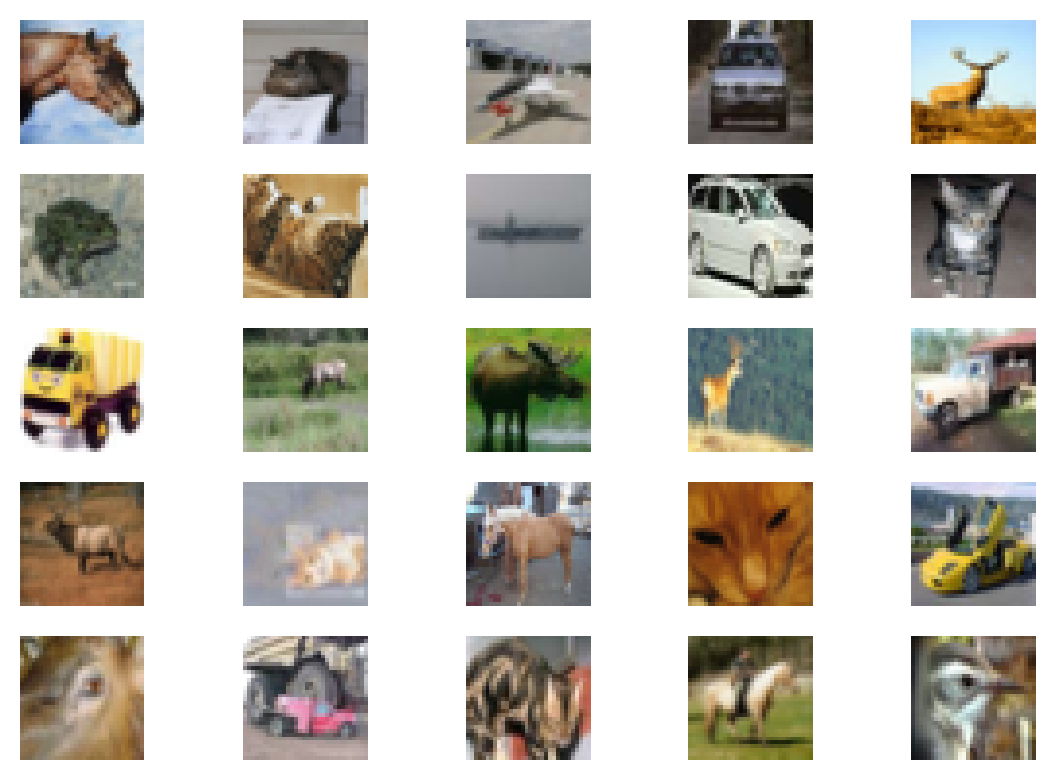

In [35]:
idx = list(np.random.choice(len(X_train), size=5*5))

fig, ax = plt.subplots(5, 5, dpi=200)
for i in range(5):
    for j in range(5):
        ax[i][j].imshow(X_train[idx.pop()])
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

In [36]:
train_dataset = tf.data.Dataset.\
                from_tensor_slices((X_train, y_train)).\
                shuffle(True).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.\
                from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

## 모델 불러오기

In [37]:
from tensorflow.keras import models, layers, losses, optimizers, metrics

In [38]:
mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')

In [39]:
class Model(models.Model):
    def __init__(self, base_model):
        super(Model, self).__init__()
        self.base_model = base_model
        self.top_layer = models.Sequential([
            layers.Dense(10),
            layers.Activation(tf.nn.softmax),
        ])
        
    def call(self, inputs, training=False):
        x = self.base_model(inputs, training=training)
        x = layers.Flatten()(x)
        outputs = self.top_layer(x, training=training)
        return outputs
    
model = Model(mobilenetv2)
model.build((None, IMG_SIZE, IMG_SIZE, 3))

In [40]:
opt = optimizers.Adam(learning_rate=ETA)
scc = losses.SparseCategoricalCrossentropy()
metric = metrics.SparseCategoricalAccuracy()
loss = metrics.Mean()
acc = metrics.Mean()

## 일단 걍 cross entropy loss 만 써보기

In [41]:
%%time
for e in range(EPOCHS):
    start = time.time()
    for inputs in train_dataset:
        _x, _y = inputs
        with tf.GradientTape() as t:
            _y_pred = model(_x, training=True)
            _loss = scc(_y, _y_pred)
        grads = t.gradient(_loss, model.trainable_variables)
        opt.apply_gradients(list(zip(grads, model.trainable_variables)))
        loss.update_state(_loss)
        acc.update_state(metric(_y, _y_pred))
    print(f"{e+1}/{EPOCHS} loss:{loss.result():.8f} acc:{acc.result()*100:.2f}% {time.time()-start:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()

1/5 loss:1.73080802 acc:32.68% 102.98 sec/epoch
2/5 loss:1.22496188 acc:46.02% 100.72 sec/epoch
3/5 loss:1.00930035 acc:52.12% 102.13 sec/epoch
4/5 loss:0.87152570 acc:56.43% 102.13 sec/epoch
5/5 loss:0.72409767 acc:59.93% 101.99 sec/epoch
CPU times: user 8min 31s, sys: 1.35 s, total: 8min 32s
Wall time: 8min 29s


In [42]:
acc.reset_states()

for inputs in train_dataset:
    _x, _y = inputs
    _y_pred = model(_x)
    acc.update_state(metric(_y, _y_pred))
    
print(f"{acc.result()*100:.2f}%")

62.46%


## 제안 방법 써보기

In [99]:
f_mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')

In [100]:
F = Model(f_mobilenetv2)
F.build((None, IMG_SIZE, IMG_SIZE, 3))

In [101]:
LAMBDA = 1e-3
MU = 1e-3
SIGMA = 1

In [102]:
%%time
for e in range(EPOCHS):
    start = time.time()
    for inputs in train_dataset:
        _x, _y = inputs
        with tf.GradientTape() as t:
            with tf.GradientTape() as tt:
                tt.watch(_x)
                _y_pred = F(_x, training=True)
                hx = 2 / SIGMA**2\
                    * ( F(_x + tf.random.normal(_x.shape, stddev=SIGMA), training=True)\
                       -_y_pred )
            _loss = scc(_y, _y_pred)\
                    + LAMBDA * (tf.reduce_mean(hx)\
                            + 1/2 * tf.norm(tt.gradient(_y_pred, _x)) \
                            + MU*tf.reduce_mean(hx**2))
        grads = t.gradient(_loss, F.trainable_variables)
        opt.apply_gradients(list(zip(grads, F.trainable_variables)))
        loss.update_state(_loss)
        acc.update_state(metric(_y, _y_pred))
    print(f"{e+1}/{EPOCHS} loss:{loss.result():.8f} acc:{acc.result()*100:.2f}% {time.time()-start:.2f} sec/epoch")
    loss.reset_states()
    acc.reset_states()

1/5 loss:1.41225398 acc:60.08% 469.58 sec/epoch
2/5 loss:1.07661974 acc:59.10% 464.29 sec/epoch
3/5 loss:0.90492904 acc:59.69% 466.20 sec/epoch
4/5 loss:0.76701158 acc:60.63% 465.87 sec/epoch
5/5 loss:0.62774682 acc:61.78% 469.73 sec/epoch
CPU times: user 40min 7s, sys: 34 s, total: 40min 41s
Wall time: 38min 55s


In [103]:
acc.reset_states()

for inputs in train_dataset:
    _x, _y = inputs
    _y_pred = model(_x)
    acc.update_state(metric(_y, _y_pred))
    
print(f"{acc.result()*100:.2f}%")

62.77%
